# Capstone Project

Notebook for Data preparation, cleaning, checking, creating models, tunning them and evaluating the best one for our image classificator



In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import shutil
import random
import numpy as np
from io import BytesIO
from PIL import Image
import requests
import urllib
from IPython.display import display


from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow import keras
import tensorflow.lite as tflite
import PIL
import PIL.Image

import matplotlib.pyplot as plt
import seaborn as sns
from random import randrange

%matplotlib inline



2023-12-18 15:43:08.132998: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-18 15:43:08.672267: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-18 15:43:08.672284: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-18 15:43:09.899995: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Dataset information

Dataset can be downloaded from: https://www.tensorflow.org/datasets/catalog/eurosat#eurosatrgb_default_config

The dataset consists of 10 different types of lands. The goal of this project is to classify different images into 1 of those 10 different classes. The classes are:

1. "AnnualCrop"
1. "Forest"
1. "HerbaceousVegetation"
1. "Highway"
1. "Industrial"
1. "Pasture"
1. "PermanentCrop"
1. "Residential"
1. "River"
1. "SeaLake"

# EDA
## Data preparation

First we load the data

AnnualCrop


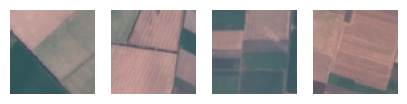

Forest


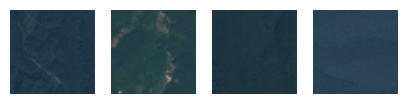

HerbaceousVegetation


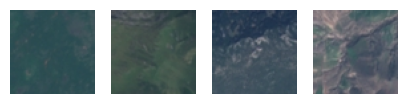

Highway


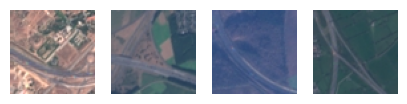

Industrial


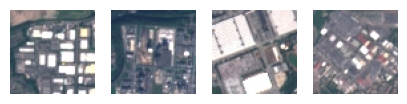

Pasture


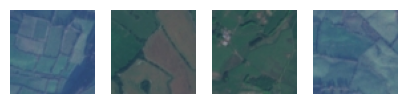

PermanentCrop


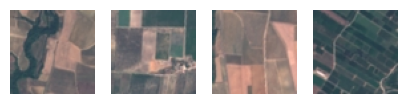

Residential


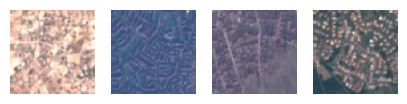

River


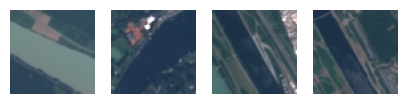

SeaLake


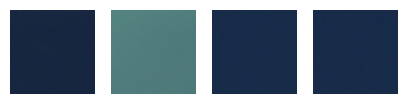

In [26]:
path = "EuroSAT_RGB/"
example = "Highway/Highway_15.jpg"
target_size = (64, 64)
classes = ["AnnualCrop","Forest","HerbaceousVegetation","Highway","Industrial","Pasture","PermanentCrop","Residential","River","SeaLake"]

# lets check some images:
n_lines = 3
for m,class_ in enumerate(classes):
    fig,axs = plt.subplots(1, 4, figsize=(5, 10))
    print (class_)
    for n in range(4):
        example = "{}/{}_{}.jpg".format(class_,class_,randrange(1000))
        axs[n].imshow(load_img("{}{}".format(path,example), target_size=target_size))
        axs[n].axis("off")
    plt.pause(0.1)
    
    


## Split Dataset into Train/Val/Test (60%/20%/20%)

In [35]:
for class_ in classes:
    images = os.listdir(os.path.join(path, class_))
    print("Type of image: %20s: %d images on folder." % (class_, len(images)))

Type of image:           AnnualCrop: 3000 images on folder.
Type of image:               Forest: 3000 images on folder.
Type of image: HerbaceousVegetation: 3000 images on folder.
Type of image:              Highway: 2500 images on folder.
Type of image:           Industrial: 2500 images on folder.
Type of image:              Pasture: 2000 images on folder.
Type of image:        PermanentCrop: 2500 images on folder.
Type of image:          Residential: 3000 images on folder.
Type of image:                River: 2500 images on folder.
Type of image:              SeaLake: 3000 images on folder.


We will use the same procedure as for machine learning models.

We will have a train, validation and test

In [36]:
for folder in ['train', 'validation', 'test']:
    for class_ in classes:
        directory = os.path.join(folder, class_)
        if not os.path.exists(directory):
            os.makedirs(directory)
            print("{} created.".format(directory))

train/AnnualCrop created.
train/Forest created.
train/HerbaceousVegetation created.
train/Highway created.
train/Industrial created.
train/Pasture created.
train/PermanentCrop created.
train/Residential created.
train/River created.
train/SeaLake created.
validation/AnnualCrop created.
validation/Forest created.
validation/HerbaceousVegetation created.
validation/Highway created.
validation/Industrial created.
validation/Pasture created.
validation/PermanentCrop created.
validation/Residential created.
validation/River created.
validation/SeaLake created.
test/AnnualCrop created.
test/Forest created.
test/HerbaceousVegetation created.
test/Highway created.
test/Industrial created.
test/Pasture created.
test/PermanentCrop created.
test/Residential created.
test/River created.
test/SeaLake created.
fulltrain/AnnualCrop created.
fulltrain/Forest created.
fulltrain/HerbaceousVegetation created.
fulltrain/Highway created.
fulltrain/Industrial created.
fulltrain/Pasture created.
fulltrain/Pe

In [37]:
np.random.seed(1)
class_dict = {}
for class_ in classes:
    images = os.listdir(os.path.join(path, class_))
    for image in images:
        class_dict[image] = class_ 
        
    list_full_train, list_test = train_test_split(images, test_size=0.2, random_state=1)
    list_train, list_val = train_test_split(list_full_train, test_size=0.25, random_state=1)
    print (class_)
    print (len(list_train),len(list_test),len(list_val))
    for image in list_train:
        shutil.copyfile("{}/{}".format(os.path.join(path, class_),image),"train/{}/{}".format(class_,image))
    for image in list_test:
        shutil.copyfile("{}/{}".format(os.path.join(path, class_),image),"test/{}/{}".format(class_,image))
    for image in list_val:
        shutil.copyfile("{}/{}".format(os.path.join(path, class_),image),"validation/{}/{}".format(class_,image))


AnnualCrop
1800 600 600
Forest
1800 600 600
HerbaceousVegetation
1800 600 600
Highway
1500 500 500
Industrial
1500 500 500
Pasture
1200 400 400
PermanentCrop
1500 500 500
Residential
1800 600 600
River
1500 500 500
SeaLake
1800 600 600


We will start creating a Convolutional Neural Network (CNN). This type of models are very good for...

converts an image into vector representation, then we have dense vectors and those are taking to do the prediction


In [31]:
def make_model():
    
    inputs = keras.Input(shape=(target_size[0], target_size[1], 3)) #matrix and all 3 colors (RGB)
    
    # convolute. Convert all values (pixesl) into single value
    conv = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inputs) 
    
    # reduce width and height
    pooling = keras.layers.MaxPool2D(strides=(2, 2))(conv)
    
    flatten = keras.layers.Flatten()(pooling)
    
    #First Dense layer
    dense = keras.layers.Dense(64, activation='relu')(flatten)
    
    #Reduce layers to number of classes
    outputs = keras.layers.Dense(len(classes), activation='softmax')(dense)
    
    model = keras.Model(inputs, outputs)
    
    ##############################################
    
    # optimizers use gradient descend
    # optimizers needs a way to know if it learns anything or not.
    optimizer = keras.optimizers.SGD(learning_rate=0.01)
   
    
    loss = keras.losses.CategoricalCrossentropy(from_logits=False) 
    # logits False because we have softmax in the output
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

initial_model = make_model()

2023-12-18 16:09:41.164700: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-12-18 16:09:41.164722: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-18 16:09:41.164738: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ibai-PC): /proc/driver/nvidia/version does not exist
2023-12-18 16:09:41.165357: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
initial_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 30752)             0         
                                                                 
 dense (Dense)               (None, 64)                1968192   
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                             

In [38]:

train_datagenerator = ImageDataGenerator(rescale=1./255)

train_data = train_datagenerator.flow_from_directory(
    "train/",
    target_size=target_size,
    batch_size=20,
    shuffle=True
)
val_datagenerator = ImageDataGenerator(rescale=1./255)

val_data = val_datagenerator.flow_from_directory(
    "validation/",
    target_size=target_size,
    batch_size=20,
    shuffle=False # no need to shuffle for validation
)


Found 16200 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [39]:
X, y = next(train_data) # to get next batch
X.shape


(20, 64, 64, 3)

In [89]:
y[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Lets's create a dictionary to easily convert later the number to the type

In [40]:
class_pred_dict = {v:k for k, v in train_data.class_indices.items()}


In [41]:
class_pred_dict

{0: 'AnnualCrop',
 1: 'Forest',
 2: 'HerbaceousVegetation',
 3: 'Highway',
 4: 'Industrial',
 5: 'Pasture',
 6: 'PermanentCrop',
 7: 'Residential',
 8: 'River',
 9: 'SeaLake'}

Let's check the accuracy of this first model

Epoch 1/20
810/810 [==============================] - 10s 12ms/step - loss: 0.6503 - accuracy: 0.7650 - val_loss: 0.5717 - val_accuracy: 0.8000
Epoch 2/20
810/810 [==============================] - 10s 12ms/step - loss: 0.6021 - accuracy: 0.7830 - val_loss: 0.4860 - val_accuracy: 0.8350
Epoch 3/20
810/810 [==============================] - 10s 12ms/step - loss: 0.5682 - accuracy: 0.7948 - val_loss: 0.5892 - val_accuracy: 0.7900
Epoch 4/20
810/810 [==============================] - 10s 12ms/step - loss: 0.5369 - accuracy: 0.8083 - val_loss: 0.7986 - val_accuracy: 0.7300
Epoch 5/20
810/810 [==============================] - 10s 12ms/step - loss: 0.4973 - accuracy: 0.8267 - val_loss: 0.8674 - val_accuracy: 0.7100
Epoch 6/20
810/810 [==============================] - 10s 12ms/step - loss: 0.4662 - accuracy: 0.8347 - val_loss: 0.8761 - val_accuracy: 0.7150
Epoch 7/20
810/810 [==============================] - 10s 12ms/step - loss: 0.4331 - accuracy: 0.8494 - val_loss: 0.6755 - val_accuracy:

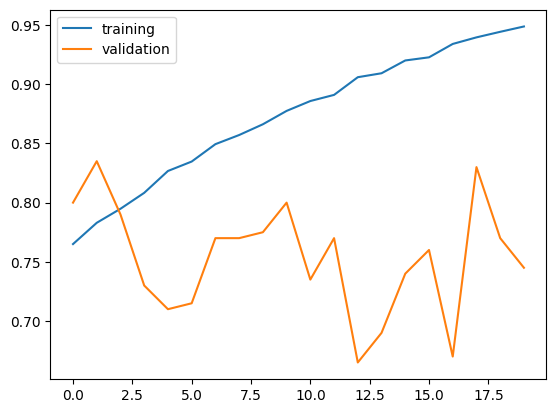

In [43]:
history = initial_model.fit(
        train_data,
        epochs=20,
        validation_data=val_data,
        validation_steps=10,
    )

plt.plot(history.history['accuracy'], label="training")
plt.plot(history.history['val_accuracy'], label="validation")
plt.legend()


With first simple model we get an accuracy of  between 0.7 and 0.85. Let's Tune parameters to improve it.

### Parameter Tunning

We will tune the learning rate, the inner layer size and the dropout rate.
We could tune more paremeters but we will stick to these three due to training time
1. learning rate: the learning rate (eta) is the most important value to adjust. Learning rate is like how fast we can read books. reading 1 book only a year is slow but we learn all the book,while if we read 1 every day maybe we do not get all the concepts, maybe we just check images and so. SO we need a medium speed
1. dropout rate: Dropuout is a way of regularizing. It is a way of preventing overfitting. Imagine that we have a tshirt with a logo. If we do many epochs, like 10, the model learns 10 times the same, and it can associate for example the logo with a tshirt. And if we see the logo  in a trouser, it could call it a tshirt. To fight this, we hide with a part of the image, for example, with a patch, so everytime it sees the image in each epoch, it will be slighly different. To do this, we can freeze different part of the network, like a neuron in the inner layer.
1. Inner layer size. Basically change the number of "neurons" of the inner layer to see if we need more due to complexity or less



In [53]:
def make_tunned_model(size_inner=64,learning_rate=0.01,dropout_rate=0.0):
    
    inputs = keras.Input(shape=(target_size[0], target_size[1], 3)) #matrix and all 3 colors (RGB)
    
    # convolute. Convert all values (pixesl) into single value
    conv = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inputs) 
    
    # reduce width and height
    pooling = keras.layers.MaxPool2D(strides=(2, 2))(conv)
    
    flatten = keras.layers.Flatten()(pooling)
    if dropout_rate != 0:
        dropout = keras.layers.Dropout(rate=dropout_rate)(flatten)
        dense = keras.layers.Dense(size_inner, activation='relu')(dropout)
    else:
        dense = keras.layers.Dense(size_inner, activation='relu')(flatten)
        
    #Reduce layers to number of classes
    outputs = keras.layers.Dense(len(classes), activation='softmax')(dense)
    
    model = keras.Model(inputs, outputs)
    
    ##############################################
    
    # optimizers use gradient descend
    # optimizers needs a way to know if it learns anything or not.
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
   
    
    loss = keras.losses.CategoricalCrossentropy(from_logits=False) 
    # logits False because we have softmax in the output
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model


Let's tune learning rate first

In [55]:
scores={}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)
    model = make_tunned_model(learning_rate=lr)
    history = model.fit(
        train_data,
        epochs=10,
        validation_data=val_data,
        validation_steps=10,
    )
    scores[lr] = history.history
    
    print()
    print()


0.0001
Epoch 1/10
810/810 [==============================] - 10s 12ms/step - loss: 2.2542 - accuracy: 0.1208 - val_loss: 1.8703 - val_accuracy: 0.9500
Epoch 2/10
810/810 [==============================] - 10s 12ms/step - loss: 2.2175 - accuracy: 0.1623 - val_loss: 1.8560 - val_accuracy: 0.8100
Epoch 3/10
810/810 [==============================] - 10s 12ms/step - loss: 2.1812 - accuracy: 0.2149 - val_loss: 1.8084 - val_accuracy: 0.7400
Epoch 4/10
810/810 [==============================] - 10s 12ms/step - loss: 2.1446 - accuracy: 0.2941 - val_loss: 1.7890 - val_accuracy: 0.7100
Epoch 5/10
810/810 [==============================] - 10s 12ms/step - loss: 2.1083 - accuracy: 0.3027 - val_loss: 1.7707 - val_accuracy: 0.6900
Epoch 6/10
810/810 [==============================] - 10s 12ms/step - loss: 2.0746 - accuracy: 0.3080 - val_loss: 1.7118 - val_accuracy: 0.6450
Epoch 7/10
810/810 [==============================] - 10s 12ms/step - loss: 2.0434 - accuracy: 0.3091 - val_loss: 1.6825 - val_ac

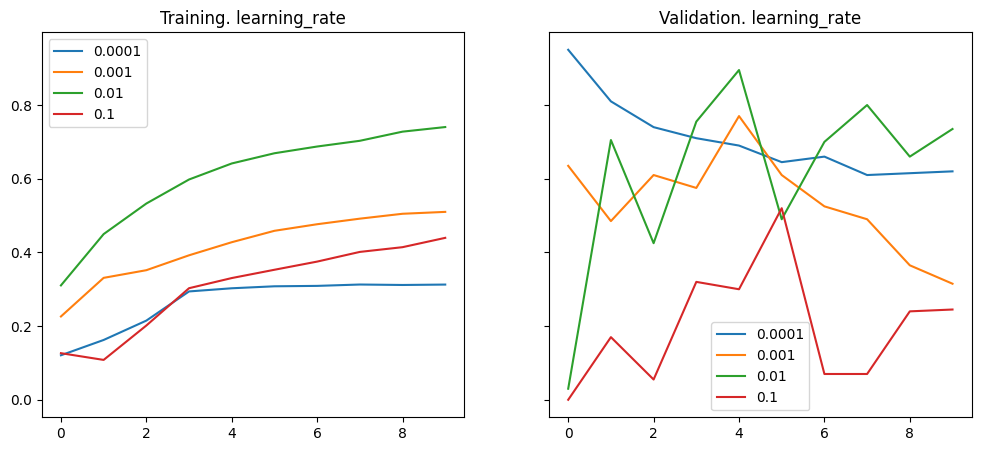

In [56]:
def plot_accuracy(scores,title):
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5),sharey=True)
    for label, hist in scores.items():
        ax1.plot(hist['accuracy'], label=label)
        ax2.plot(hist['val_accuracy'], label=label)
    ax1.legend()
    ax2.legend()
    #ax1.set_ylim([0.5,1])
    ax1.set_title("Training. {}".format(title))
    ax2.set_title("Validation. {}".format(title))


plot_accuracy(scores,"learning_rate")

# we can see that it is very close to 1 the training, while for validation not more than 80, which is overfitting.


In [57]:
best_learning_rate = 0.01

Best learning rate is: 0.01

Now let's tune the dropout rate.

In [60]:
scores={}

for dropout_rate in [0, 0.1, 0.2, 0.3, 0.4, 0.5]:
    print(dropout_rate)
    model = make_tunned_model(learning_rate=best_learning_rate, dropout_rate=dropout_rate)
    history = model.fit(
        train_data,
        epochs=10,
        validation_data=val_data,
        validation_steps=10,
    )
    scores[dropout_rate] = history.history
    
    print()
    print()

0
Epoch 1/10
810/810 [==============================] - 11s 13ms/step - loss: 1.8295 - accuracy: 0.2921 - val_loss: 1.5566 - val_accuracy: 0.3750
Epoch 2/10
810/810 [==============================] - 10s 12ms/step - loss: 1.5491 - accuracy: 0.4221 - val_loss: 1.2190 - val_accuracy: 0.7350
Epoch 3/10
810/810 [==============================] - 10s 12ms/step - loss: 1.3250 - accuracy: 0.5223 - val_loss: 1.0094 - val_accuracy: 0.7300
Epoch 4/10
810/810 [==============================] - 10s 12ms/step - loss: 1.1596 - accuracy: 0.5890 - val_loss: 1.5665 - val_accuracy: 0.2150
Epoch 5/10
810/810 [==============================] - 10s 12ms/step - loss: 1.0396 - accuracy: 0.6313 - val_loss: 0.5964 - val_accuracy: 0.8100
Epoch 6/10
810/810 [==============================] - 10s 12ms/step - loss: 0.9565 - accuracy: 0.6570 - val_loss: 1.0213 - val_accuracy: 0.6750
Epoch 7/10
810/810 [==============================] - 10s 12ms/step - loss: 0.8895 - accuracy: 0.6814 - val_loss: 1.0368 - val_accurac

810/810 [==============================] - 11s 13ms/step - loss: 0.8649 - accuracy: 0.6855 - val_loss: 0.7679 - val_accuracy: 0.7500
Epoch 8/10
810/810 [==============================] - 11s 14ms/step - loss: 0.8205 - accuracy: 0.7056 - val_loss: 0.9535 - val_accuracy: 0.7000
Epoch 9/10
810/810 [==============================] - 11s 14ms/step - loss: 0.7715 - accuracy: 0.7251 - val_loss: 0.6246 - val_accuracy: 0.7700
Epoch 10/10
810/810 [==============================] - 11s 14ms/step - loss: 0.7370 - accuracy: 0.7314 - val_loss: 0.8068 - val_accuracy: 0.7400




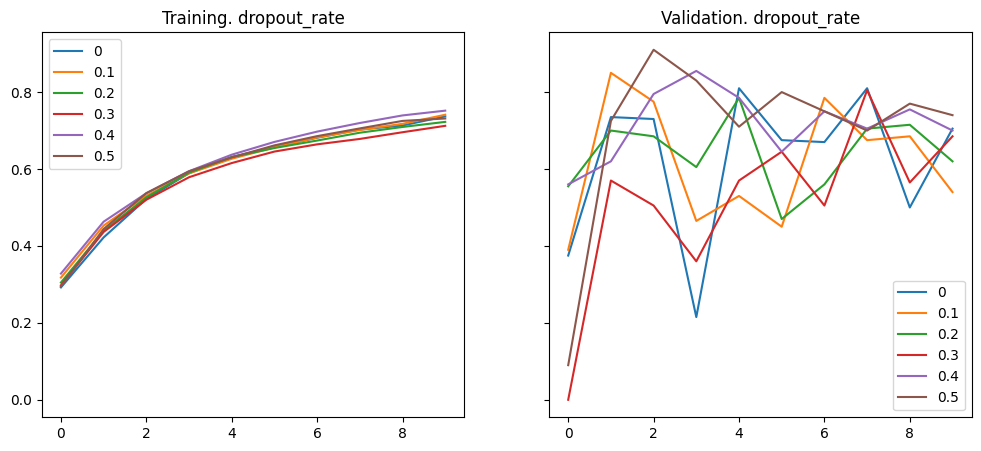

In [61]:
plot_accuracy(scores,"dropout_rate")

In [62]:
best_dropout_rate = 0.5

Best dropout rate is: 0.5

Finally, let's tune the inner layer size.

In [63]:
scores={}
for inner_size in [10, 100, 1000]:
    print(inner_size)
    model = make_tunned_model(size_inner = inner_size, learning_rate = best_learning_rate, dropout_rate = best_dropout_rate)
    history = model.fit(
        train_data,
        epochs=10,
        validation_data=val_data,
        validation_steps=10,
    )
    scores[inner_size] = history.history
    
    print()
    print()

0.5
Epoch 1/10
810/810 [==============================] - 10s 12ms/step - loss: 2.1338 - accuracy: 0.2073 - val_loss: 1.5600 - val_accuracy: 0.6700
Epoch 2/10
810/810 [==============================] - 10s 12ms/step - loss: 1.7111 - accuracy: 0.3561 - val_loss: 1.4407 - val_accuracy: 0.6500
Epoch 3/10
810/810 [==============================] - 10s 12ms/step - loss: 1.5133 - accuracy: 0.4318 - val_loss: 1.0949 - val_accuracy: 0.6800
Epoch 4/10
810/810 [==============================] - 10s 13ms/step - loss: 1.4248 - accuracy: 0.4694 - val_loss: 1.3908 - val_accuracy: 0.4650
Epoch 5/10
810/810 [==============================] - 10s 12ms/step - loss: 1.3373 - accuracy: 0.5113 - val_loss: 1.2298 - val_accuracy: 0.6650
Epoch 6/10
810/810 [==============================] - 10s 12ms/step - loss: 1.2728 - accuracy: 0.5400 - val_loss: 1.0407 - val_accuracy: 0.7500
Epoch 7/10
810/810 [==============================] - 10s 12ms/step - loss: 1.1988 - accuracy: 0.5653 - val_loss: 1.4215 - val_accur

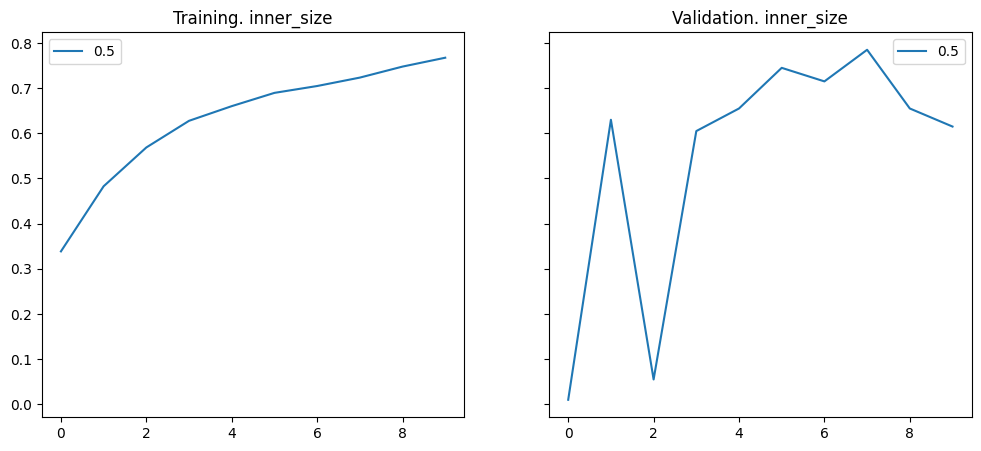

In [64]:
plot_accuracy(scores,"inner_size")

In [73]:
best_inner_size = 100

Now we have a final model.

We will compare to an already created model like xception and apply transfer learning to see if it is better than our model.

Normally, the learning into vector representation of many models is very generic. But the dense layers afterwars are specific to the dataset.
SO we want to keep the convolutional layers (the first ones) and train the dense layers.
So we reuse the learning knowledge and that is transfer learning

In [46]:
# here code with xception model or another one and a fit. witha  plot of accuracy

### Regularization: Data augmentation

Now, let's do data augmentation

this is another way for regularization. We generate more data from existing data. This also prevents from seeing the same image over and over again.


In [67]:
augmented_train_gen = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=30,
    #width_shift_range=10.0,
    #height_shift_range=10.0,
    shear_range=10,
    zoom_range=0.1,
    vertical_flip=True,
  )


# we do not apply augmentation to the validation because we want to compare with something consistent always

augmented_train_data = augmented_train_gen.flow_from_directory(
    "train/",
    target_size=target_size,
    batch_size=20,
    shuffle=True
)
scores={}
model = make_tunned_model(size_inner = best_inner_size, learning_rate = best_learning_rate, dropout_rate = best_dropout_rate)
history = model.fit(
    augmented_train_data,
    epochs=10,
    validation_data=val_data,
    validation_steps=10,
)
scores["augmented"] = history.history

print()
print()

Found 16200 images belonging to 10 classes.
Epoch 1/10
810/810 [==============================] - 76s 94ms/step - loss: 1.7701 - accuracy: 0.3205 - val_loss: 0.9618 - val_accuracy: 0.8150
Epoch 2/10
810/810 [==============================] - 76s 94ms/step - loss: 1.4963 - accuracy: 0.4450 - val_loss: 1.7320 - val_accuracy: 0.2600
Epoch 3/10
810/810 [==============================] - 76s 94ms/step - loss: 1.2705 - accuracy: 0.5436 - val_loss: 2.3919 - val_accuracy: 0.2400
Epoch 4/10
810/810 [==============================] - 76s 94ms/step - loss: 1.1182 - accuracy: 0.5988 - val_loss: 1.2774 - val_accuracy: 0.5200
Epoch 5/10
810/810 [==============================] - 76s 93ms/step - loss: 1.0317 - accuracy: 0.6306 - val_loss: 1.0145 - val_accuracy: 0.6650
Epoch 6/10
810/810 [==============================] - 77s 96ms/step - loss: 0.9659 - accuracy: 0.6495 - val_loss: 0.8507 - val_accuracy: 0.7250
Epoch 7/10
810/810 [==============================] - 79s 98ms/step - loss: 0.9087 - accurac

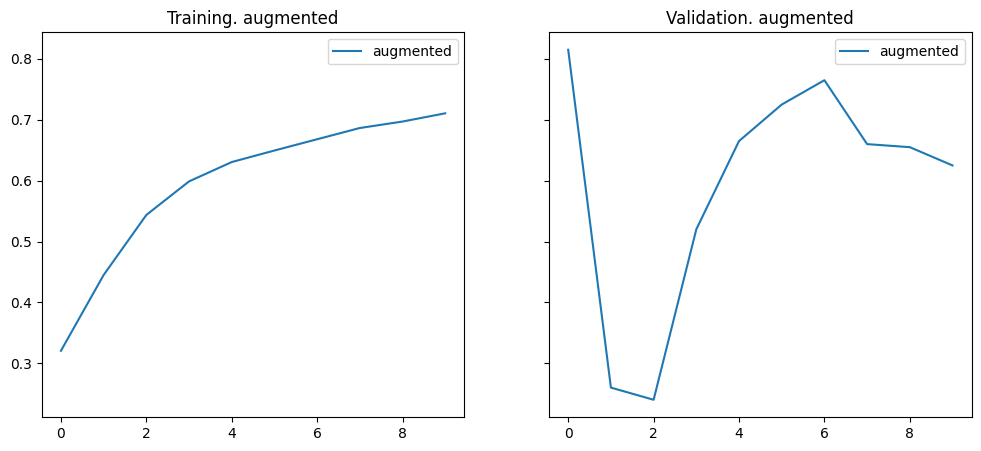

In [68]:
plot_accuracy(scores,"augmented")

Augmentation does not really help. We get similar or less accuracy 

Let's just create our final model.

Also, let's create checkpoints to get the model with the best accuracy.

Checpointing means saving the model in the iterations with highest scores, like the peaks in the plots when training.


In [69]:
#let's save the default model first.
model.save_weights('map_model_v1.h5', save_format=('h5'))


In [70]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'map_model_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True, #this is a variable that saves when it is the best compared to the past models
    monitor='val_accuracy',
    mode='max'
)

In [75]:
model = make_tunned_model(size_inner = best_inner_size, learning_rate = best_learning_rate, dropout_rate = best_dropout_rate)
scores={}
history = model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
    callbacks=[checkpoint]
)
scores["final_model"] = history.history


Epoch 1/20
810/810 [==============================] - 14s 17ms/step - loss: 1.7865 - accuracy: 0.3223 - val_loss: 1.6517 - val_accuracy: 0.3650
Epoch 2/20
810/810 [==============================] - 14s 18ms/step - loss: 1.4572 - accuracy: 0.4711 - val_loss: 1.2852 - val_accuracy: 0.5350
Epoch 3/20
810/810 [==============================] - 14s 18ms/step - loss: 1.2314 - accuracy: 0.5586 - val_loss: 1.0744 - val_accuracy: 0.6224
Epoch 4/20
810/810 [==============================] - 14s 17ms/step - loss: 1.0855 - accuracy: 0.6090 - val_loss: 1.0450 - val_accuracy: 0.6096
Epoch 5/20
810/810 [==============================] - 14s 18ms/step - loss: 0.9764 - accuracy: 0.6475 - val_loss: 0.9163 - val_accuracy: 0.6689
Epoch 6/20
810/810 [==============================] - 14s 18ms/step - loss: 0.8966 - accuracy: 0.6759 - val_loss: 0.9311 - val_accuracy: 0.6680
Epoch 7/20
810/810 [==============================] - 15s 18ms/step - loss: 0.8379 - accuracy: 0.6930 - val_loss: 0.9558 - val_accuracy:

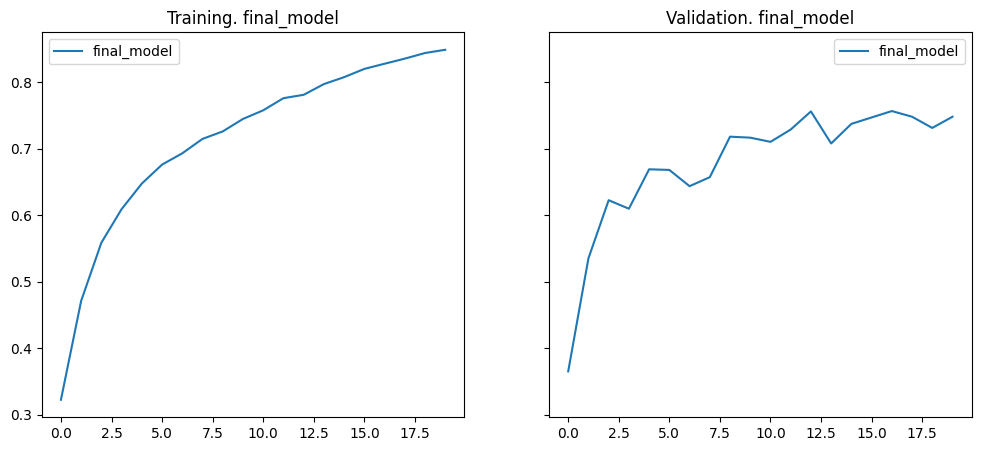

In [76]:
plot_accuracy(scores,"final_model")

### TEST

In [77]:
test_datagenerator = ImageDataGenerator(rescale=1./255)

test_data = test_datagenerator.flow_from_directory(
    "test/",
    target_size=target_size,
    batch_size=20,
    shuffle=False # no need to shuffle for test
)


Found 5400 images belonging to 10 classes.


In [79]:
pred_test = model.predict_generator(test_data)
predicted_class_indices_test = np.argmax(pred_test,axis=1)
predictions = [class_pred_dict[p] for p in predicted_class_indices_test]
cm = confusion_matrix([class_pred_dict[p] for p in predicted_class_indices_test], 
                 [class_pred_dict[l] for l in test_data.labels], 
                 labels=list(class_pred_dict.values()))
print(f'accuracy: {sum(predicted_class_indices_test == test_data.labels) / len(predicted_class_indices_test)}')


accuracy: 0.7507407407407407


[Text(0, 0.5, 'AnnualCrop'),
 Text(0, 1.5, 'Forest'),
 Text(0, 2.5, 'HerbaceousVegetation'),
 Text(0, 3.5, 'Highway'),
 Text(0, 4.5, 'Industrial'),
 Text(0, 5.5, 'Pasture'),
 Text(0, 6.5, 'PermanentCrop'),
 Text(0, 7.5, 'Residential'),
 Text(0, 8.5, 'River'),
 Text(0, 9.5, 'SeaLake')]

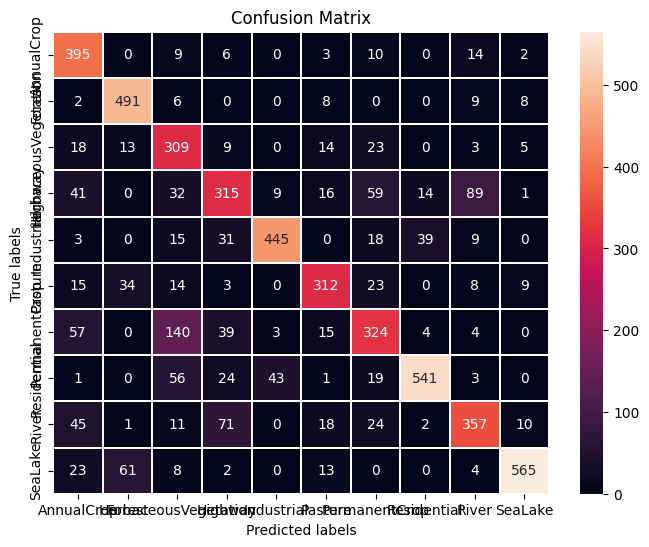

In [80]:
f, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, linewidths=0.1)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(list(class_pred_dict.values()))
ax.yaxis.set_ticklabels(list(class_pred_dict.values()))

### Save model

In [82]:
model_path = 'map_model-v1.tflite'

final_model = keras.models.load_model("map_model_17_0.756.h5")

converter = tflite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

with open(model_path, 'wb') as f_out:
    f_out.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpxzte5df1/assets


INFO:tensorflow:Assets written to: /tmp/tmpxzte5df1/assets
2023-12-18 18:02:51.523596: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-12-18 18:02:51.523625: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-12-18 18:02:51.523776: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxzte5df1
2023-12-18 18:02:51.525544: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-12-18 18:02:51.525560: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxzte5df1
2023-12-18 18:02:51.530667: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-12-18 18:02:51.573776: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxzte5df1
2023-12-18 18:02:51.586106: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

In [83]:
final_model.evaluate(test_data) # first number is categorical crossentropy, the second is the accuracy.

270/270 [==============================] - 2s 5ms/step - loss: 0.6695 - accuracy: 0.7646


[0.6694576144218445, 0.764629602432251]

### Prediction on a single image by final model

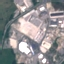

In [86]:
from keras.preprocessing import image

img = load_img('test/Industrial/Industrial_89.jpg',target_size=target_size)
img

In [105]:
X = np.array([img])
pred = model.predict(X)
print (class_pred_dict[np.argmax(pred,axis=1)[0]])

1/1 [==============================] - 0s 15ms/step
Industrial


Instructions and code of the work carried out 

I first created a notebook called notebook.ipynb where I downloaded the data, explored, prepared the data, cleaned, run different models with different parameters, evaluated them and concluded which was the model that performed the best.

Then I generated the train.py script that trains the models and saves the model to a file with pickle, the predict.py file that loads the model and serves it and the test.py script that will be used to predict a specific day.

Then I created and environment and installed the libraries I will be using: pipenv install numpy scikit-learn flask gunicorn xgboost

Then I run the environment with: pipenv shell

I run a server locally: gunicorn --bind 0.0.0.0:9696 predict:app

I test that the model is working with: python3 test.py

After checking that it works, I create a docker container sudo docker build -t midterm_project ..
We can test it running the docker image docker run -it --rm  midterm_project and executing python3 test.py

Finally I deploy it to AWS with Elastic Beanstalk. 
For that I first install the library pipenv install awsebcli --dev, initialize EB eb init -p docker -r eu-north-1 midterm_project and create the service eb create midterm-project-env

Now we just need to test it. For that, I modified the line pointing to the url in test.py and run python3 test.py. (There is no need to change it now since the server is still running in AWS (today being 5 November 2023))

In [ ]:
next pipenv

pip install pipenv
pipenv install
pipenv shell
python predict.py

[[source]]
url = "https://pypi.org/simple"
verify_ssl = true
name = "pypi"

[packages]
scikit-learn = "==1.0"
flask = "*"
gunicorn = "*"
tensorflow = "*"
pillow = "*"

[dev-packages]

[requires]
python_version = "3.8"

In [ ]:
test locally.
We need to get script from notebook to load model
we also need to create python files like gateway, proto test and so on.
say also why we are using tensorflow lite

In [ ]:
create docker

FROM tensorflow/serving:2.7.0

COPY clothing_model /models/clothing-model/1
ENV MODEL_NAME="clothing-model"

In [ ]:
test docker locally
